# Sequential Frequency Analysis of Victorian Literature: 
### Wuthering Heights and Frankenstein, with Python
David Almonte

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.filterwarnings('ignore')
from urllib.request import urlopen
from datascience import Table
from sklearn import preprocessing
%matplotlib inline

### Introduction

This project uses python to build text-oriented metadata for two books - Mary Shelley's *Frankenstein* and Charlotte Bronte's *Wuthering Heights*. 

Three areas of interest reflect in the project code and visualizations:

1. Pronoun prevalence
2. Character appearance density
3. Use of emotive punctuation

This project uses the above books for two key reasons:

1. Both books originated roughly contemporaneously (1823 for *Frankensteins*, and 1847 for *Heights*), and would have been available to similar audiences.
2. Female authorship has notably influenced the content and themes of both books

These are character-driven stories, and there might be something to learn about the plot by *plotting* character mentions and involvement throughout each tale. Lower character mentions for characters with specific traits might indicate an artistic or social preference towards certain modes of engagement and interaction. 

Could the object of this paper be achieved by actually *reading* both of these books? Yes. Would we learn more about Victorian Literature by performing human function *read_book()* rather than python function *read_url()*? Probably also yes. 

But computers are fast, and programs are scalable. And sometimes, writing code to describe literature might be more valuable than writing lengthy prose to analyze it. Rarely, but inevitably sometimes. 

### Analyzing Character Appearance in the Books

This project procedes by accessing the digitally contained, copyright free, fair-use versions of both books currently available at the Gutenberg project. You're free to click through these links to read either [Wuthering Heights](http://www.gutenberg.org/cache/epub/768/pg768.txt) or [Frankenstein](https://www.gutenberg.org/files/84/84-0.txt) if you wish, but thats not at all why you're here. 

We begin by building a custom function to read, decode, and tidy the scraped web text from Gutenberg. Two variables point to the full text. The text is then scanned for the presence of a trigger word separating chapters. In *Heights* it takes the form of an all-caps "CHAPTER" string, while in *Frankenstein* it takes the form of a sentencecase "Chapter" string. Since *Frankenstein's* gutenberg version also used the same string 24 times in the table of contents, we exclude the first 24 mentions of "Chapter" in the book from analysis.

In [2]:
def read_url(url):
    """
    Input: URL string
    Output: parsed text from gutenberg project page
    """
    book_text = re.sub('\\s+', ' ', urlopen(url).read().decode())
    return book_text


wuthering_url = 'http://www.gutenberg.org/cache/epub/768/pg768.txt'
wuthering_txt = read_url(wuthering_url)
    
    
franken_url='https://www.gutenberg.org/files/84/84-0.txt'
franken_txt=read_url(franken_url)

In [3]:
# Split each book into chapters using headings
wuthering_chapters = wuthering_txt.split('CHAPTER ')[1:34]
franken_chapters = franken_txt.split('Chapter ')[25:] # TOC Includes split phrase so omit

In [4]:
# Display the chapters of both books in a table.
Table().with_columns('Wuthering Chapters', wuthering_chapters[0:5], 
                     'Frankenstein Chapters', franken_chapters[0:5])

Wuthering Chapters,Frankenstein Chapters
I 1801.--I have just returned from a visit to my landlor ...,"1 I am by birth a Genevese, and my family is one of the ..."
II Yesterday afternoon set in misty and cold. I had half ...,2 We were brought up together; there was not quite a yea ...
"III While leading the way upstairs, she recommended that ...",3 When I had attained the age of seventeen my parents re ...
"IV What vain weathercocks we are! I, who had determined ...","4 From this day natural philosophy, and particularly che ..."
V In the course of time Mr. Earnshaw began to fail. He h ...,5 It was on a dreary night of November that I beheld the ...


Once we've parsed the text, we can begin to build a shadow/fascimile of the story, by plotting the occurence of the names of characters throughout the books. To do this, we use a helper function that scans a list of words and returns a dataframe with the number of mentions of each of those words for each chapter in each book. 

#### Plotting the Plot

In [5]:
# Generates a pandas dataframe with per chapter mentions for each for each person
def mentions_by_chapter(names, chapters):
    """
    Inputs: list of string names, full chapter text
    Output: dict with number of mentions of each character in a chapter
    """
    mention_df = pd.DataFrame({ppl : np.char.count(chapters, ppl)
                               for ppl in names},
                              index = range(1, len(chapters) + 1)) # index by chap. num
    return mention_df

With the untold power to find and sequence the mentions of character names through the books, we can now begin to construct some very basic visualizations using cumulative frequencies.

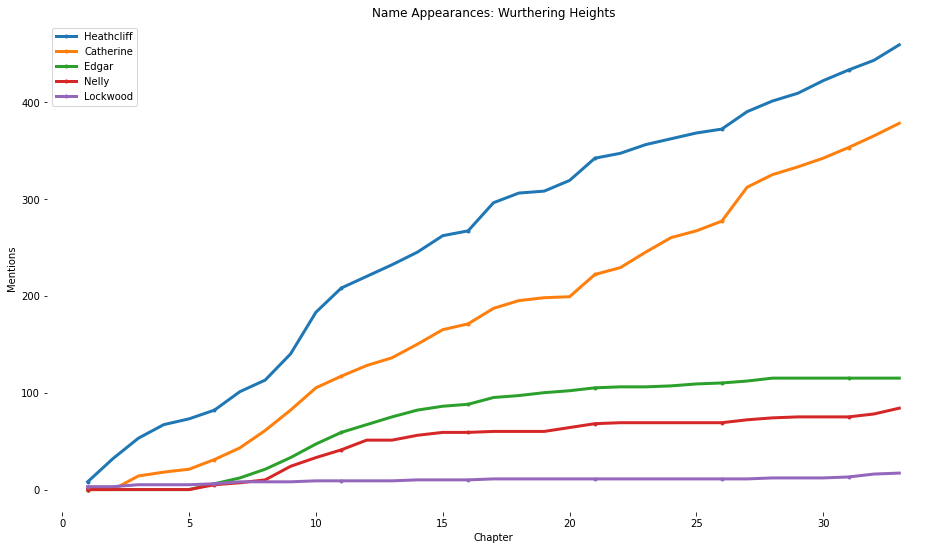

In [51]:
wuthering_people = ['Heathcliff', 'Catherine', 'Edgar', 'Nelly', 'Lockwood']
wuthering_character_counts = mentions_by_chapter(wuthering_people, wuthering_chapters)


# Build  A Plot. Wait not that kind of plot.
wuthering_char_cumsums = wuthering_character_counts.cumsum()
wuthering_char_cumsums.plot(style='.-', markevery=5, figsize=(16,9), linewidth = 3)
plt.title('Name Appearances: Wurthering Heights')
plt.legend(loc='upper left')
plt.xlabel('Chapter')
plt.ylabel('Mentions')
plt.box(False);

Our google search to get the names of Wurthering Heights' characters could also have told us much about the narrative, and given us summaries of character involvement. But this python code tells us slightly less nuanced but perhaps similarly important things. Notably, that it remains possible that the most important chapter for Catherine occurs approximately 26 chapters into the novel, or the possiblity that those characters earlier introduced (Edgar, Nelly, and Lockwood) might see their roles taper out as the story progresses. 

#### Frankensteins and their monster
Text analysis of the name mentions in frankensteins are slightly more complex than those in Wuthering Heights, for the mere fact that Frankenstein's characters have both a first and last name affixed. Of course, characters are overwhelmingly refered to by their first names - this is not *The Economist* afterall. 


Additionally, the numerous characters in the story are from the Frankenstein family, and have the same last name. 

These two, minor challenges, reflect in the much more complicated scraping code below.

In [7]:
def fn_ln_mentions(character, full_name, chapters):
    """
    Inputs: 
    1. Character name list with first name, last name, and full name
    2. The full name of the person
    3. The chapters to scan for the persons name
    Outputs: pandas dataframe with character mentions
    """
    counts = mentions_by_chapter(character, chapters)
    counts[full_name] = -1 * counts[full_name] # subtract mentions of the full name
    counts = counts.sum(axis=1)
    return counts


franken_chars = ['monster', 'Victor', 'my father', 'William']
franken_bobby = ['Robert', 'Walton', 'Robert Walton']
franken_lizzy = ['Elizabeth', 'Lavenza', 'Elizabeth Lavenza']
franken_henry = ['Henry', 'Clervel', 'Henry Clervel']


franken_bobby_counts = fn_ln_mentions(franken_bobby, 'Robert Walton', franken_chapters)
franken_lizzy_counts = fn_ln_mentions(franken_lizzy, 'Elizabeth Lavenza', franken_chapters)
franken_henry_counts = fn_ln_mentions(franken_henry, 'Henry Clervel', franken_chapters)



franken_character_counts = mentions_by_chapter(franken_chars, franken_chapters)
franken_character_counts = pd.concat([franken_character_counts,
                                      franken_bobby_counts,
                                      franken_lizzy_counts,
                                      franken_henry_counts],
                                      axis=1)

name_dict = {"monster": 'Frankensteins Monster', 'my father': 'Alphonse',
             0:'Robert', 1:'Elizabeth', 2: 'Henry'}

franken_character_counts.rename(columns = name_dict, inplace = True)

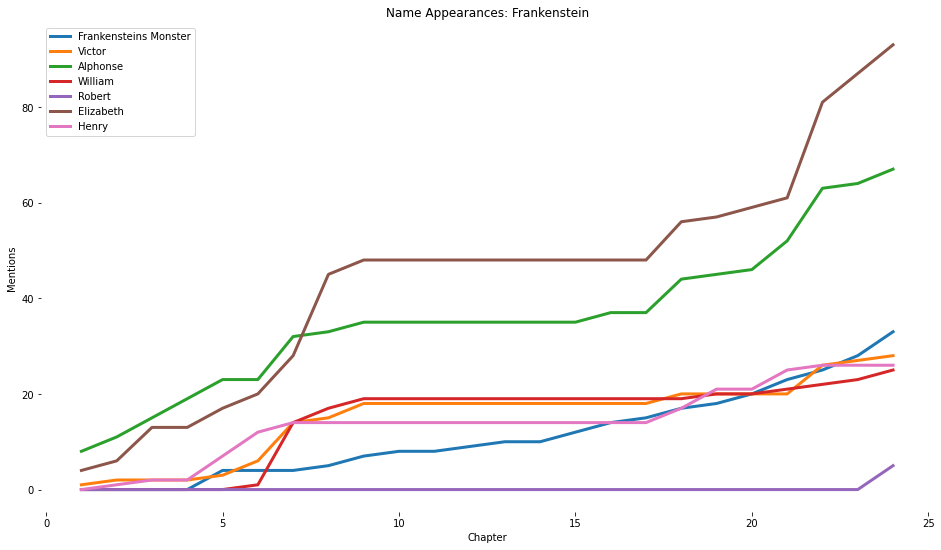

In [48]:
franken_character_cumsums = franken_character_counts.cumsum()
franken_character_cumsums.plot(figsize=(16,9), linewidth=3)
plt.title('Name Appearances: Frankenstein')
plt.xlabel('Chapter')
plt.ylabel('Mentions')
plt.box(False);

### Pronoun Analysis

What if we tried to count all the uses of female and male pronouns?

While our previous functions to count the number of character mentions worked well because names are almost always capitalizaed and reflect an unmistable combination of the same .

While its possible, for example that the string "Victor" begins a sentence that actually begins with the english word "Victorious" it's not so likely that it will render our analysis useless. On the other hand, the "he" that occurs in "the" and "other" and "here" and "hello" and "help" and "theoretically" may frequently be mistaken. Consequently, for pronoun analysis, we need to restrict our search to gramatically permissible permutations of that pronoun.

There are ways to ensure that the mention we parse is actually a pronoun: for example, "He " with a capital H, followed by a space, is unmistakably a pronoun. Similarly, " she" proceded by a space and followed by either annother space or some form of punctuation, will also be a pronoun.

We build a helper function to let us scan all of these possible permuatations. 

In [9]:
# Helper functions
def add_punctuation(pronouns):
    """
    Inputs: a list of pronouns
    Outputs: a list of each possible combination of pronoun and punctuation
    """
    punctuated = []
    marks = [' ','!', ".", "?", ',', ')', "'"]
    
    for pronoun in pronouns:
        for mark in marks:
            punctuated.append(pronoun + mark)
            
    return punctuated


female_pronouns = [' she', ' her',' hers']
male_pronouns = [' he', ' his', ' him']


female_pronouns = add_punctuation(female_pronouns) + ['She ', 'Her ', 'Hers ', 'She,']
male_pronouns = add_punctuation(male_pronouns) + ['He ', 'He,', 'His ', 'Him ']

In [10]:
def chapter_len_col(chapters):
    """
    Inputs: dataframe of strings, preferably chapters
    Outputs: dataframe of chapter lengths, in characters 
    """
    chapter_lengths = pd.DataFrame([len(i) for i in chapters],
                                   index = range(1, len(chapters) +1))
    chapter_lengths.columns = ['Length']
    return chapter_lengths


wuthering_lens = chapter_len_col(wuthering_chapters)
franken_lens   = chapter_len_col(franken_chapters)

In [11]:
#concatenate male and female proun dfs foreach book
def join_pronoun_frames(male, female, chapters, length_vec):
    """
    Inputs: male - list of male pronouns, female - list of female pronouns, chapters - text of the book
    lengthvec - vector of the lengths of each chapter # 
    Outputs:
    """
    pronouns = pd.concat([mentions_by_chapter(female, chapters).sum(axis=1),
                         mentions_by_chapter(male, chapters).sum(axis=1),
                         length_vec], axis = 1)
    pronouns.columns = ['Female', 'Male', 'Length']
    return pronouns


franken_pronouns   = join_pronoun_frames(male_pronouns, female_pronouns, franken_chapters, franken_lens)
wuthering_pronouns = join_pronoun_frames(male_pronouns, female_pronouns, wuthering_chapters, wuthering_lens)

In [12]:
def normed_pronoun_rates(df):
    """
    Inputs: 3 Column dataframe with headers 'Female', 'Male', and 'Length'
    Outputs: 2 Column dataframe with minmax scaled rates
    """
    min_max_scaler = preprocessing.MinMaxScaler()
    
    rates = pd.concat([df['Male']  /df['Length'],
                       df['Female']/df['Length']],
                       axis =1)
    
    vals = rates.values
    scaled_vals = min_max_scaler.fit_transform(vals)
    return pd.DataFrame(scaled_vals)


franken_pronouns_rates = normed_pronoun_rates(franken_pronouns)
wurther_pronouns_rates = normed_pronoun_rates(wuthering_pronouns)


cols = ['Male', 'Female']
franken_pronouns_rates.columns, wurther_pronouns_rates.columns = cols, cols

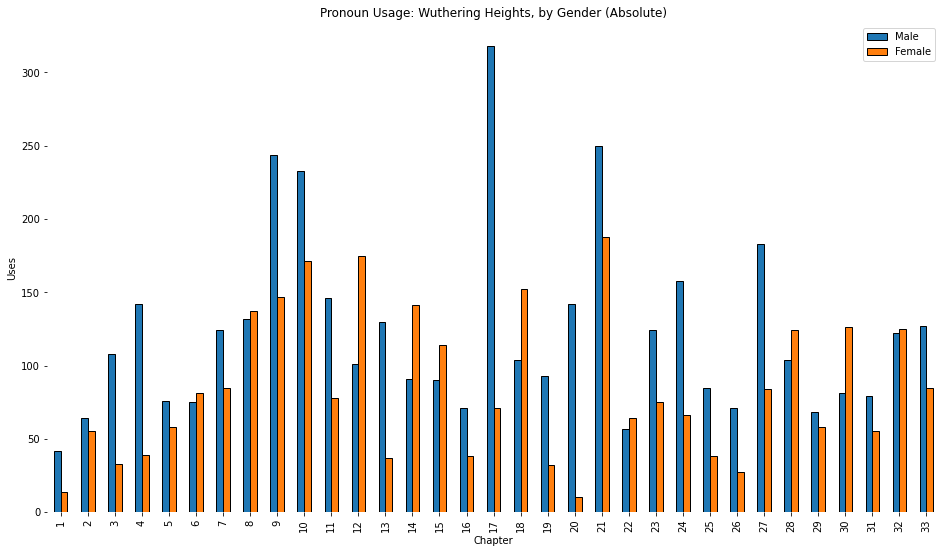

In [38]:
wuthering_pronouns[['Male', 'Female']].plot(figsize=(16,9), kind = 'bar')
plt.title('Pronoun Usage: Wuthering Heights, by Gender (Absolute)')
plt.xlabel('Chapter')
plt.ylabel('Uses')
plt.box(False);

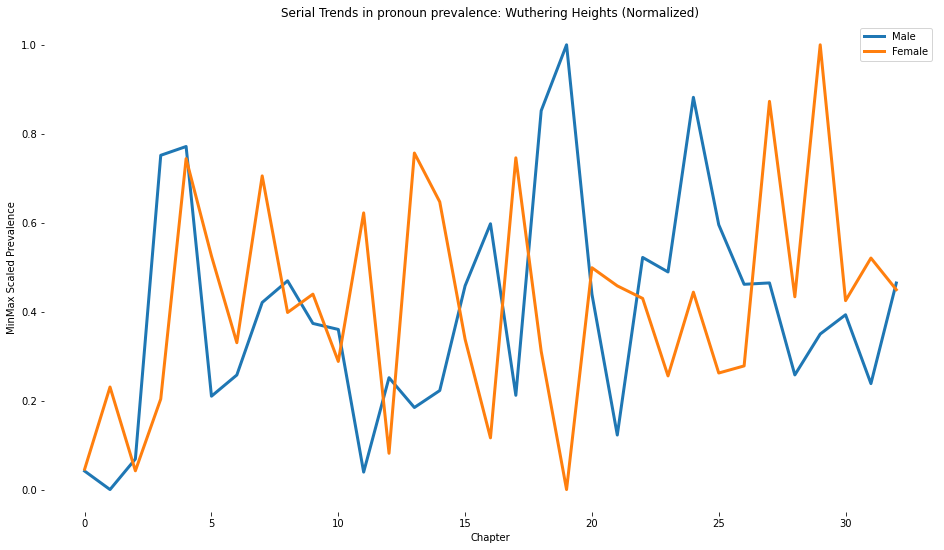

In [52]:
wurther_pronouns_rates.plot(figsize=(16,9), linewidth = 3)
plt.title('Serial Trends in pronoun prevalence: Wuthering Heights (Normalized)')
plt.ylabel('MinMax Scaled Prevalence')
plt.xlabel('Chapter')
plt.legend(loc = 'upper right')
plt.box(False);

Certain points on this incredibly noisy graph are more illustrative than others: it doesn't look as if a high density of female pronoun usage in one chapter predicts high density in the next: in fact the lack of flat lines and plentitude of peaks seems to imply that chapters with high density of female presenting pronouns more likley than not precede chapters with a lower density, and vice versa. Reference to female characters implicitly lags behind reference to male characters: male mentions in the first graph outpace female mentions throughout the story.

The most likely explanation is heavy reference to Healthcliff, the most reference character in Wuthering Heights.

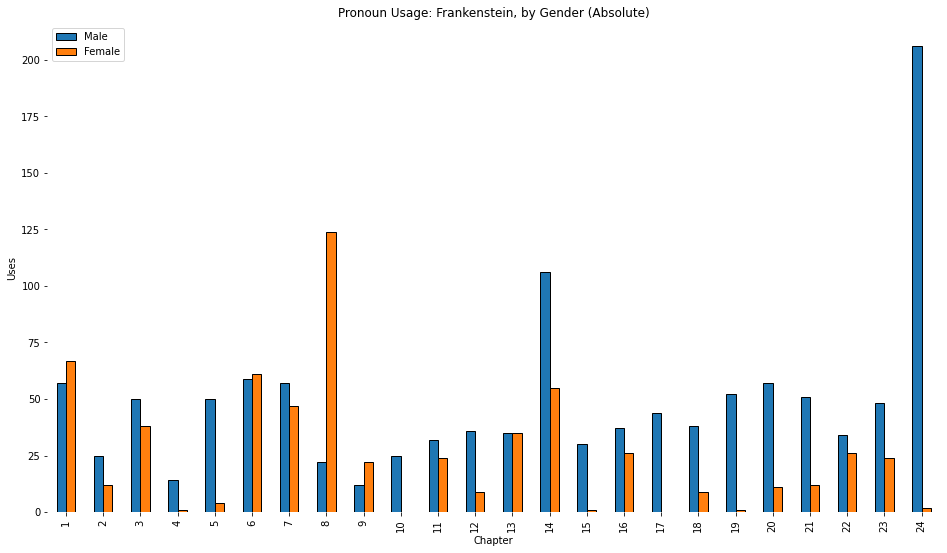

In [44]:
franken_pronouns[['Male', 'Female']].plot(figsize=(16,9), kind = 'bar')
plt.title('Pronoun Usage: Frankenstein, by Gender (Absolute)')
plt.xlabel('Chapter')
plt.ylabel('Uses')
plt.box(False);

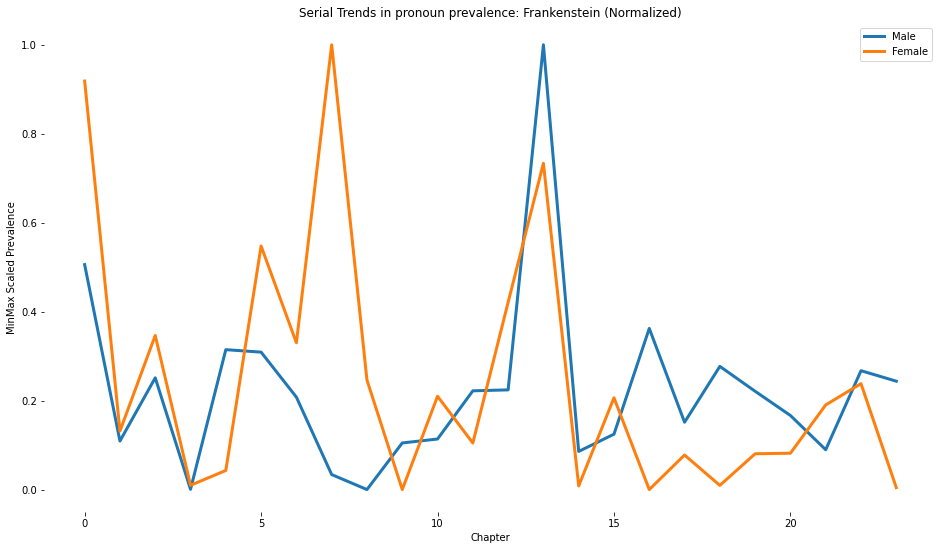

In [54]:
franken_pronouns_rates.plot(figsize=(16,9), linewidth = 3)
plt.title('Serial Trends in pronoun prevalence: Frankenstein (Normalized)')
plt.ylabel('MinMax Scaled Prevalence')
plt.xlabel('Chapter')
plt.box(False);

In Frankenstein, the plots of absolute mentions and normalized mentions of pronouns are much, much less variable. Mentions, and the rate of mentions, seem to be heavily concentrated in chapters 7 and 13 - unfortunately for us non-readers, we cannot infer why.

Notably, the number of total male mentions skyrockets for the final chapters, while the number of female mentions craters: both mentions are at low relative densities: we can infer a notably lengthy chapter. Or, perhaps an epilogue that our initialized chapter parser didn't catch. Alas, we won't know unless we crack open the book. 